This notebook compares three histogram calculation methods for an image: one over the image's relative value range, one over its absolute data type range (the "true" method), and a third "pseudo-absolute" method that attempts to reconstruct the absolute histogram from the relative one. It demonstrates that this "pseudo-absolute" method is fundamentally flawed, producing a significantly different and inaccurate result compared to the true absolute histogram. But also that maybe those differences are usually tiny. :)

In [1]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

BINS = 256



In [2]:
def compute_histogram_relative(img):
    vmin, vmax = img.min(), img.max()
    hist, edges = np.histogram(img, bins=BINS, range=(vmin, vmax), density=True)
    return hist, edges, vmin, vmax


def compute_histogram_pseudo_absolute(hist_rel, edges_rel, vmin, vmax, dtype):
    """
    Redistribute relative-histogram mass into absolute bins by overlapping intervals.
    
    Args:
        hist_rel (np.ndarray): The histogram counts or density from the relative range.
        edges_rel (np.ndarray): The bin edges for the relative histogram.
        vmin (float): Minimum value of the image's relative range.
        vmax (float): Maximum value of the image's relative range.
        dtype (np.dtype): The data type of the original image.
        
    Returns:
        tuple: A tuple containing the pseudo-absolute histogram density and bin centers.
    """
    if np.issubdtype(dtype, np.integer):
        info = np.iinfo(dtype)
        amin, amax = info.min, info.max
    else:
        # Check if the float image's values are within the 0-1 range
        if vmin >= 0 and vmax <= 1:
            amin, amax = 0, 1
        else:
            amin, amax = vmin, vmax

    # Absolute bin edges and centers
    edges_abs = np.linspace(amin, amax, BINS + 1)
    centers_abs = (edges_abs[:-1] + edges_abs[1:]) / 2
    abs_width = (amax - amin) / BINS
    
    mass_abs = np.zeros(BINS)
    
    # Vectorized calculation of mass redistribution
    for i in range(BINS):
        start_rel, end_rel = edges_rel[i], edges_rel[i + 1]
        width_rel = end_rel - start_rel

        if width_rel <= 0:
            continue

        # The mass for this relative bin (hist_rel is a density)
        mass_i = hist_rel[i] * width_rel

        # Calculate overlap for all absolute bins at once
        overlap = np.maximum(0, np.minimum(end_rel, edges_abs[1:]) - np.maximum(start_rel, edges_abs[:-1]))
        
        # Add mass to absolute bins proportional to the overlap
        mass_abs += mass_i * (overlap / width_rel)

    # Convert the total mass back to a density and return
    hist_pseudo = mass_abs / abs_width
    return hist_pseudo, centers_abs


def compute_histogram_absolute(img):
    # Determine absolute range based on data type
    if np.issubdtype(img.dtype, np.integer):
        info = np.iinfo(img.dtype)
        amin, amax = info.min, info.max
    else:
        # Check if the float image's values are within the 0-1 range
        if img.min() >= 0 and img.max() <= 1:
            amin, amax = 0, 1
        else:
            amin, amax = img.min(), img.max()
            
    # Handle the case of an image with a single pixel value
    if amax - amin < 1e-6:
        # Set a small range around the single value to create a valid histogram
        amin = amin - 0.5
        amax = amax + 0.5
    
    # Compute the histogram density over the absolute range
    hist, edges = np.histogram(img, bins=BINS, range=(amin, amax), density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    
    return hist, centers


In [3]:
def plot_histograms(img, title=None):

    # relative histogram
    h_rel, edges_rel, vmin, vmax = compute_histogram_relative(img)
    centers_rel = (edges_rel[:-1] + edges_rel[1:]) / 2

    # pseudo-absolute histogram
    h_pseudo, centers_abs = compute_histogram_pseudo_absolute(h_rel, edges_rel, vmin, vmax, img.dtype)

    # true absolute histogram
    h_abs, _ = compute_histogram_absolute(img)

    # difference
    diff = h_abs - h_pseudo

    # 1x4 subplots: True abs | Pseudo-abs | Rel range | Diff
    fig = make_subplots(
        rows=1, cols=4,
        subplot_titles=('Relative range','True absolute', 'Pseudo-absolute', 'Absolute vs Pseudo diff')
    )

    # Plot each histogram on the single row
    fig.add_trace(go.Bar(x=centers_rel, y=h_rel, name='Relative'), row=1, col=1)
    fig.add_trace(go.Bar(x=centers_abs, y=h_abs, name='Absolute'), row=1, col=2)
    fig.add_trace(go.Bar(x=centers_abs, y=h_pseudo, name='Pseudo-absolute'), row=1, col=3)
    fig.add_trace(go.Bar(x=centers_abs, y=diff, name='Diff'), row=1, col=4)

    # label axes and remove legend
    for r, c in [(1, 1), (1, 2), (1, 3), (1, 4)]:
        fig.update_xaxes(title_text='Pixel value', row=r, col=c)
        
    fig.update_layout(
        height=400,
        width=1500,
        title_text=title or '',
        showlegend=False
    )
    fig.show()

In [4]:

def generate_test_images():

    tests = {}

    # --- User's original uint8 test cases ---
    # Small ranges for uint8
    rngs8 = [(50, 101), (0, 127), (10, 55), (250, 255), (100, 101), (0, 5)]
    for lo, hi in rngs8:
        tests[f'uint8_range_{lo}_{hi}'] = np.random.randint(lo, hi + 1, (100, 100), dtype=np.uint8)

    # --- User's original uint16 test cases ---
    # Various ranges for uint16
    rngs16 = [(1000, 5000), (20000, 40000), (0, 65535), (30000, 30010)]
    for lo, hi in rngs16:
        tests[f'uint16_range_{lo}_{hi}'] = np.random.randint(lo, hi + 1, (100, 100), dtype=np.uint16)
        
    # --- User's original float32 test cases ---
    # Random floats in a small and mid-range
    tests['float32_small'] = (np.random.rand(100, 100) * 0.01) + 0.5
    tests['float32_within_0_1'] = np.random.rand(100, 100).astype(np.float32) * 0.5 + 0.1 # This will have min > 0 and max < 1
    tests['float32_mid'] = (np.random.rand(100, 100) * 20) + 1000

    # --- Additional test cases for different scenarios ---
    # Full range images for different data types
    tests['uint8_full_range'] = np.random.randint(0, 256, (100, 100), dtype=np.uint8)
    tests['uint16_full_range'] = np.random.randint(0, 65536, (100, 100), dtype=np.uint16)
    
    # Constant value images
    tests['uint8_constant_128'] = np.full((100, 100), 128, dtype=np.uint8)
    
    # Gradient images
    tests['uint8_gradient'] = np.linspace(0, 255, 10000, dtype=np.uint8).reshape((100, 100))
    
    # Images with only two values
    # Corrected the TypeError by casting the result to the desired dtype
    tests['uint8_binary'] = np.random.choice([0, 255], (100, 100)).astype(np.uint8)
    
    return tests

In [5]:
images = generate_test_images()
print(f"Generated {len(images)} test images.")
for name, img in images.items():
    print(f"- {name}: shape={img.shape}, dtype={img.dtype}, min={img.min()}, max={img.max()}")

Generated 18 test images.
- uint8_range_50_101: shape=(100, 100), dtype=uint8, min=50, max=101
- uint8_range_0_127: shape=(100, 100), dtype=uint8, min=0, max=127
- uint8_range_10_55: shape=(100, 100), dtype=uint8, min=10, max=55
- uint8_range_250_255: shape=(100, 100), dtype=uint8, min=250, max=255
- uint8_range_100_101: shape=(100, 100), dtype=uint8, min=100, max=101
- uint8_range_0_5: shape=(100, 100), dtype=uint8, min=0, max=5
- uint16_range_1000_5000: shape=(100, 100), dtype=uint16, min=1000, max=5000
- uint16_range_20000_40000: shape=(100, 100), dtype=uint16, min=20000, max=40000
- uint16_range_0_65535: shape=(100, 100), dtype=uint16, min=10, max=65535
- uint16_range_30000_30010: shape=(100, 100), dtype=uint16, min=30000, max=30010
- float32_small: shape=(100, 100), dtype=float64, min=0.5000008449538754, max=0.5099985962870702
- float32_within_0_1: shape=(100, 100), dtype=float32, min=0.10000578314065933, max=0.5999168157577515
- float32_mid: shape=(100, 100), dtype=float64, min=1

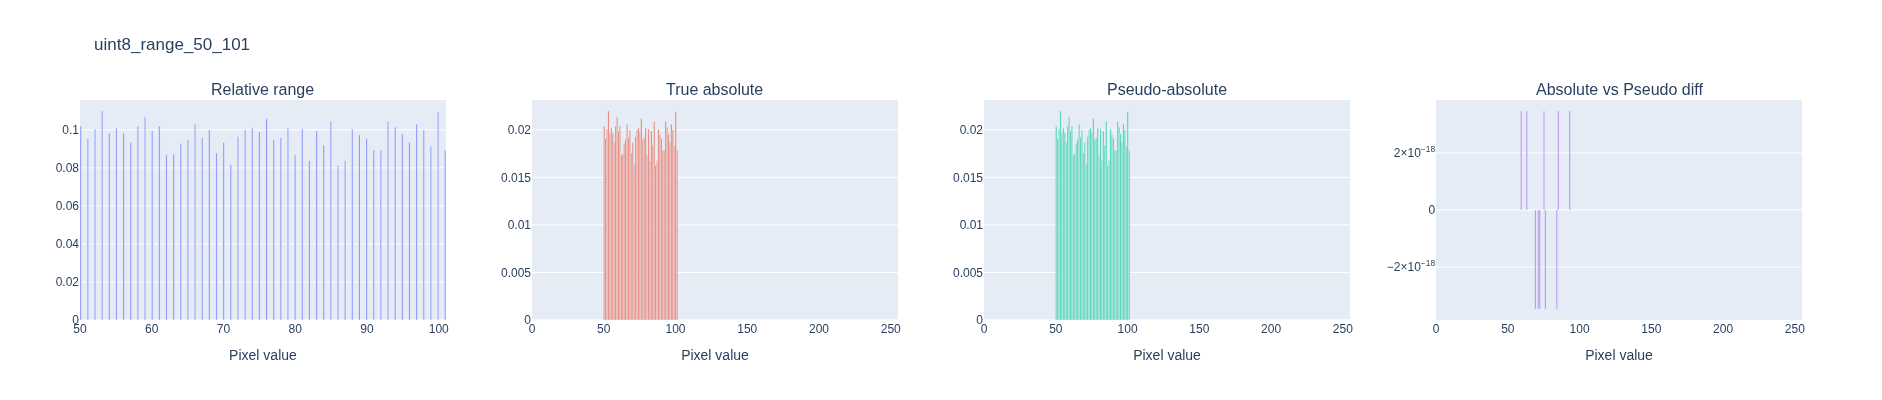

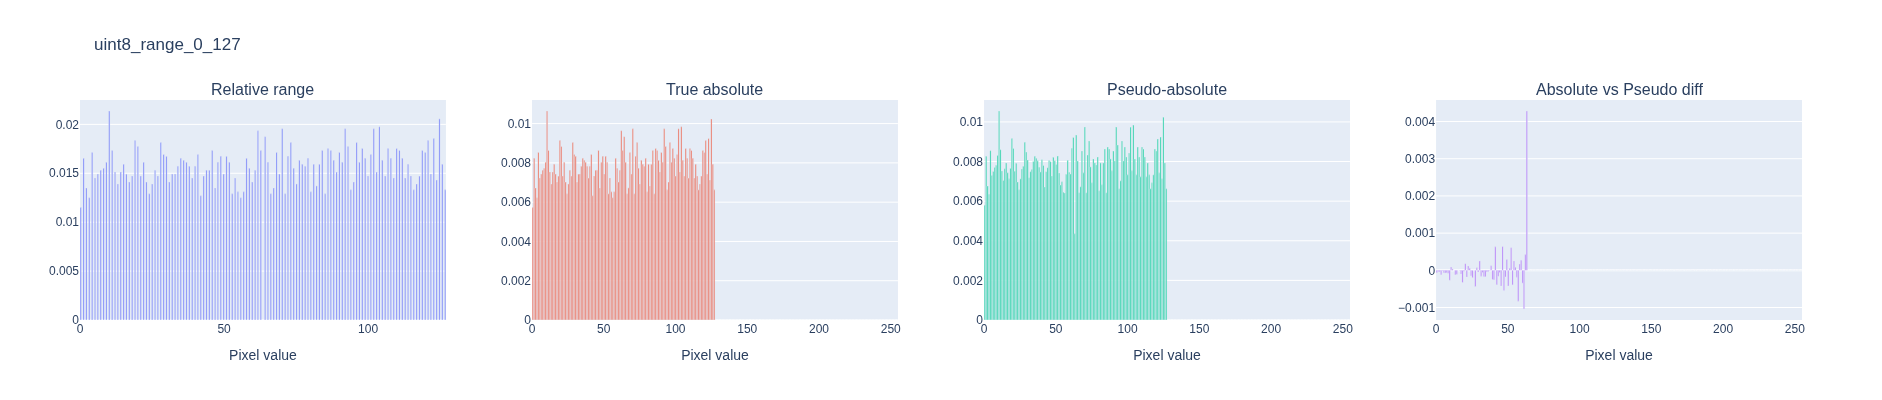

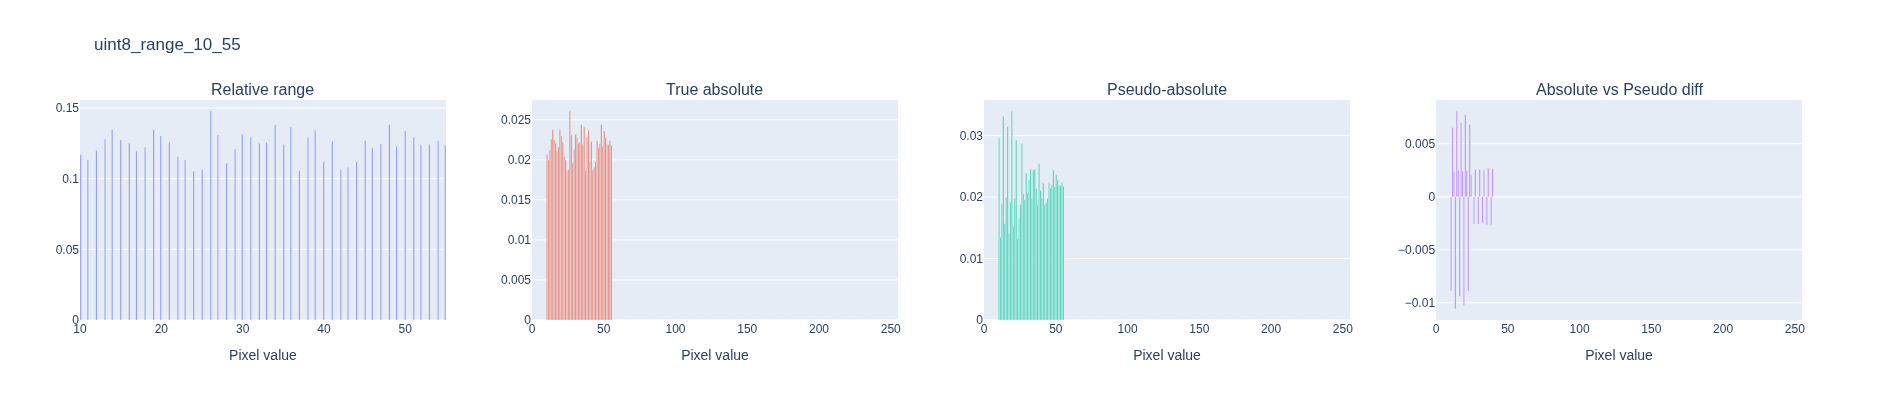

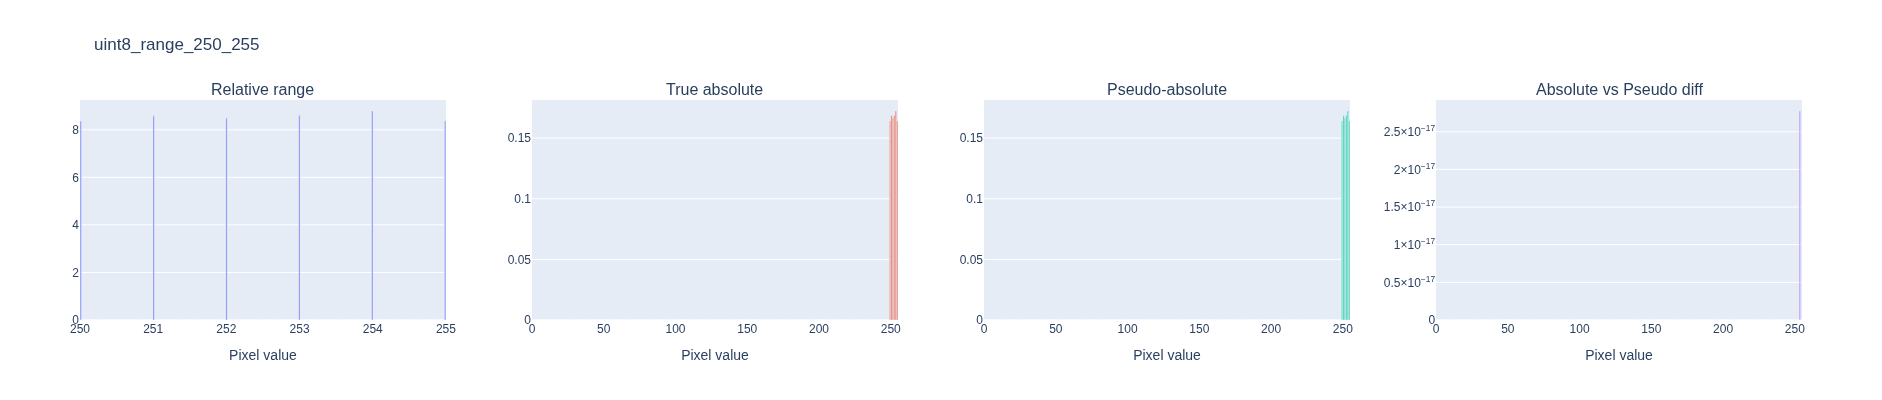

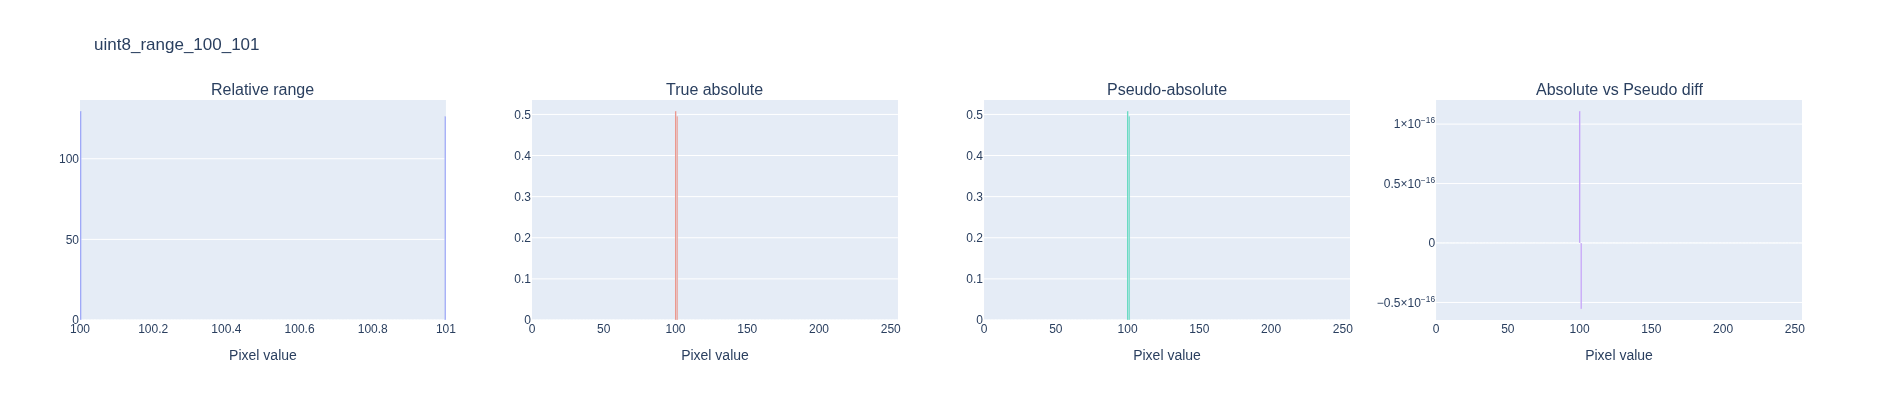

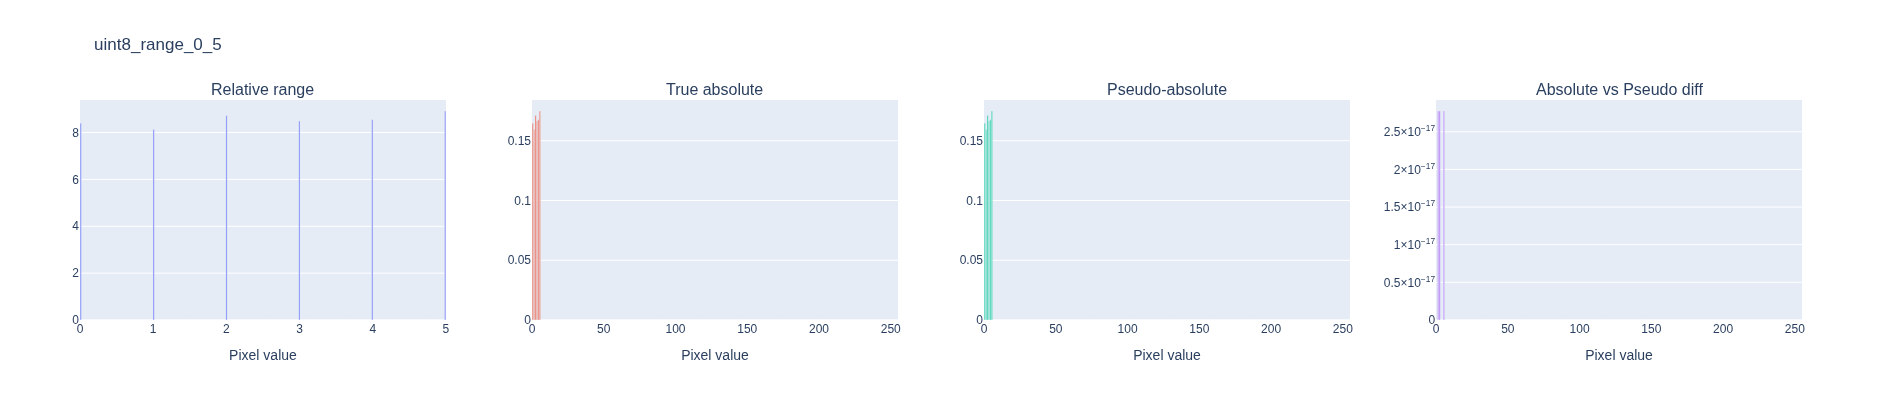

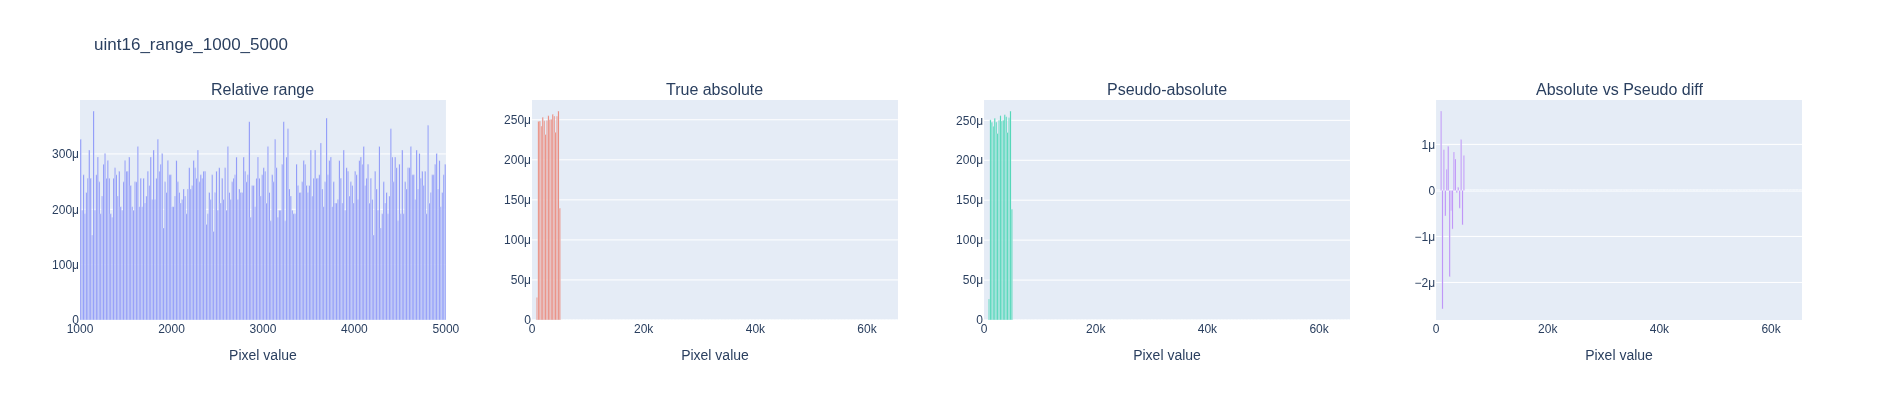

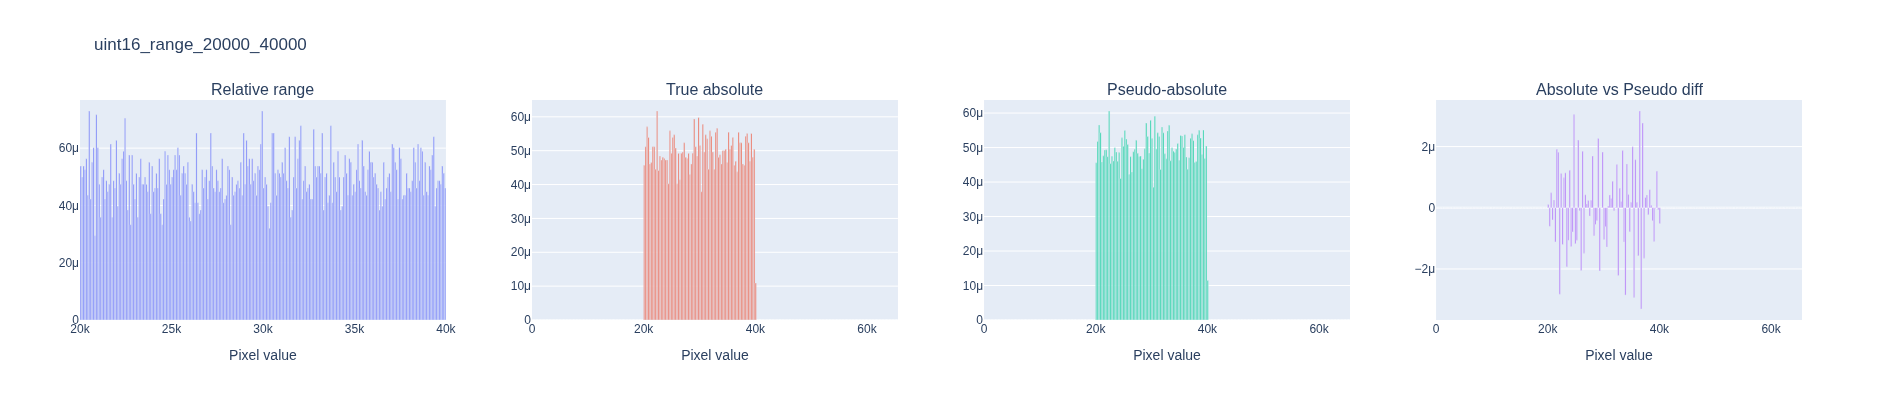

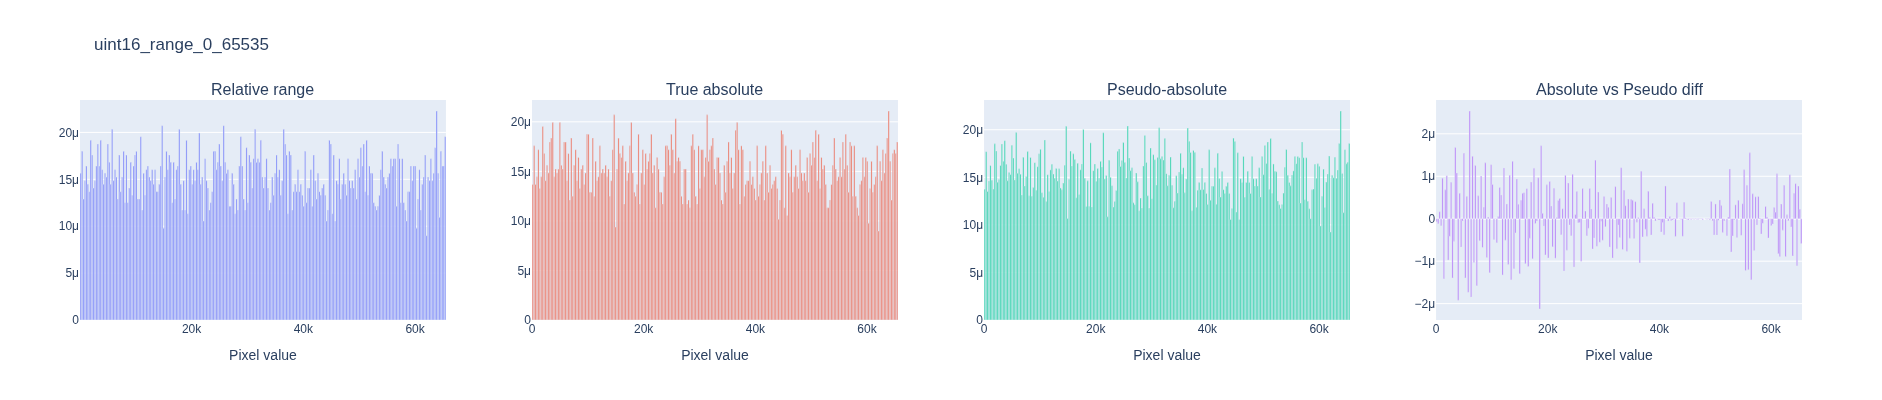

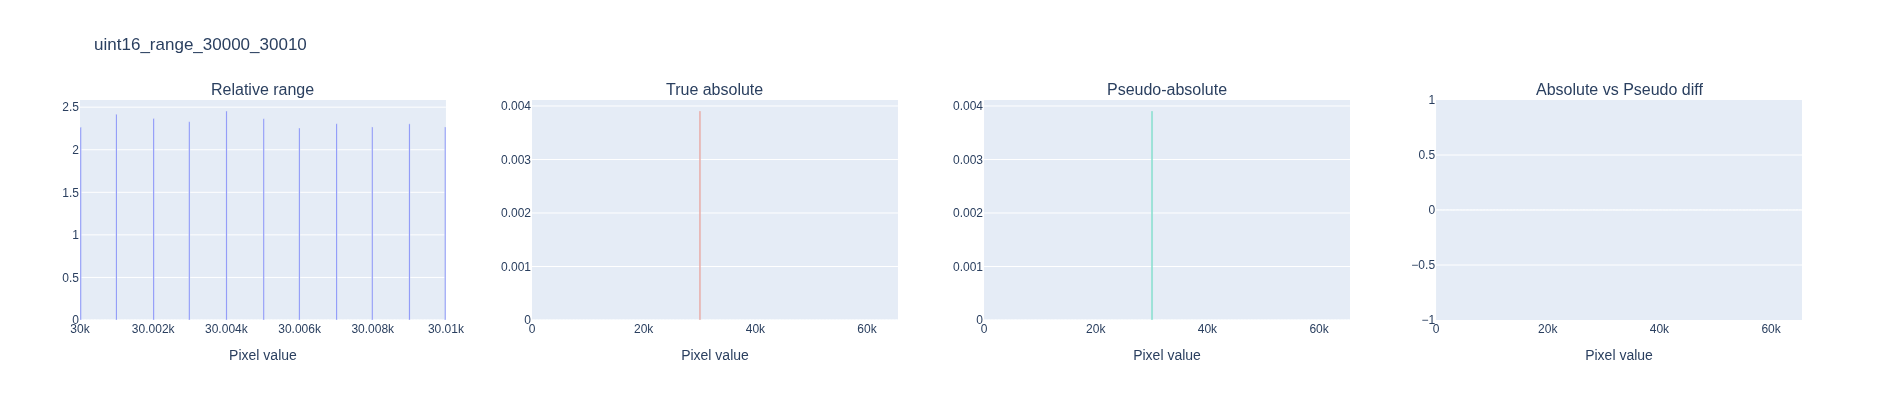

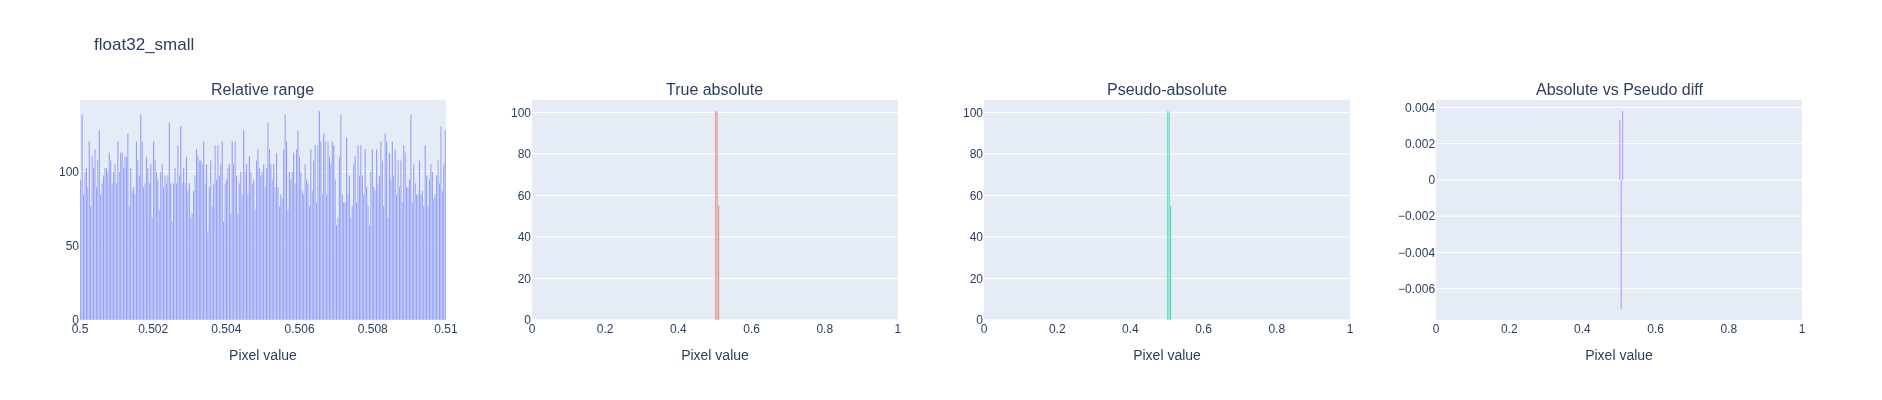

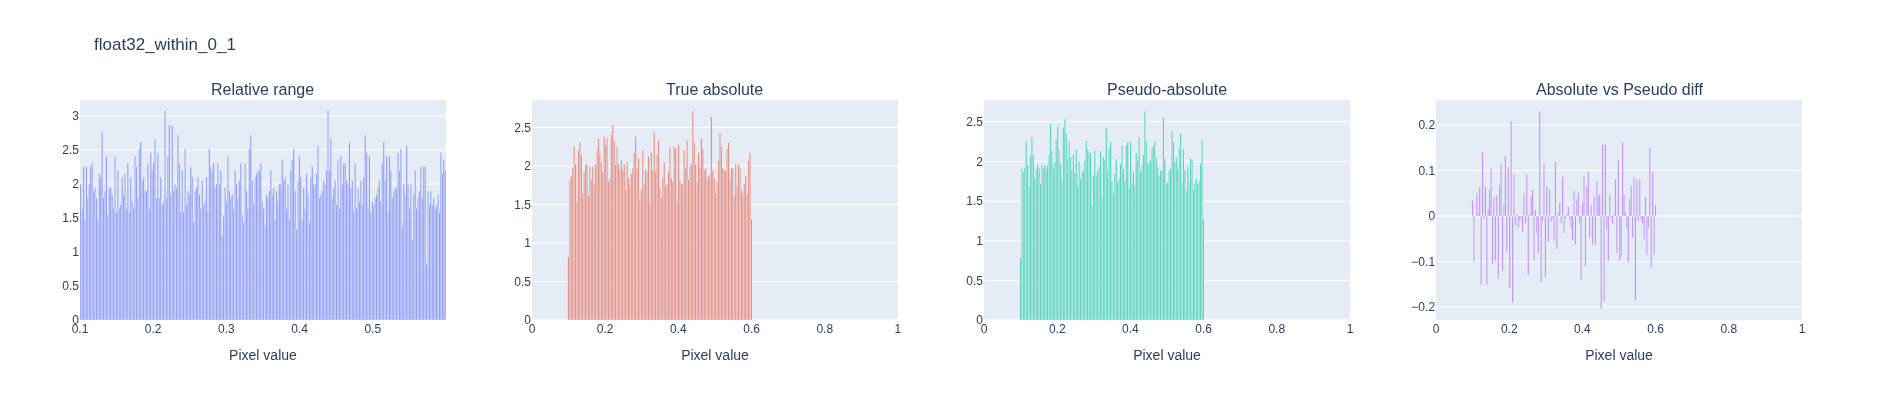

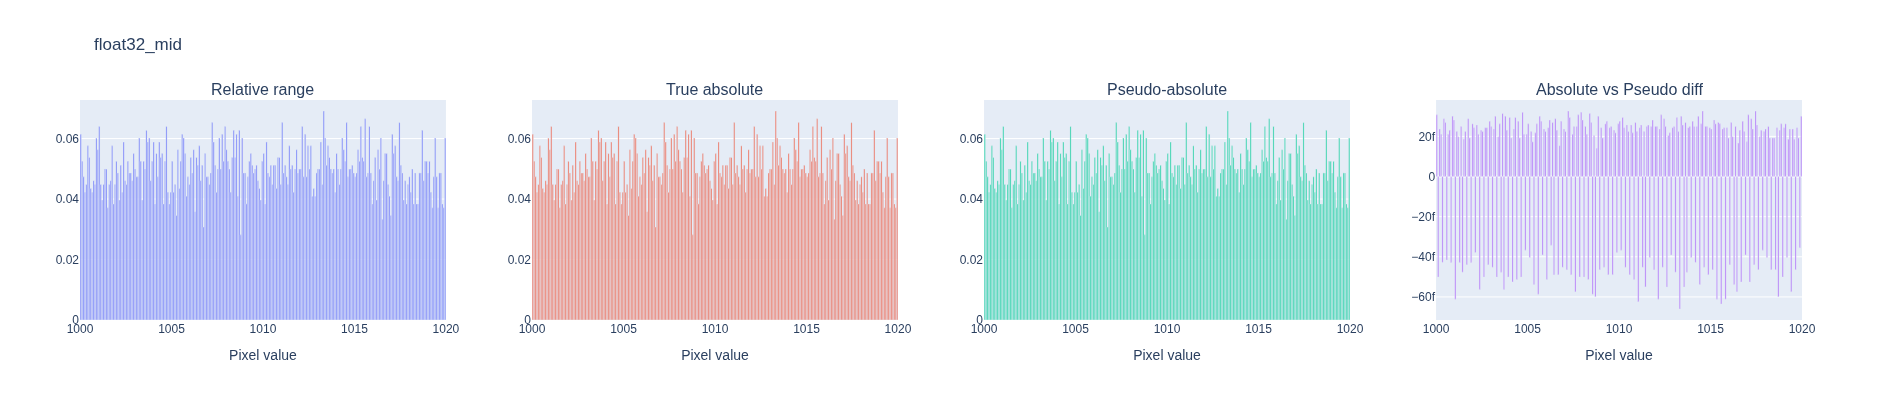

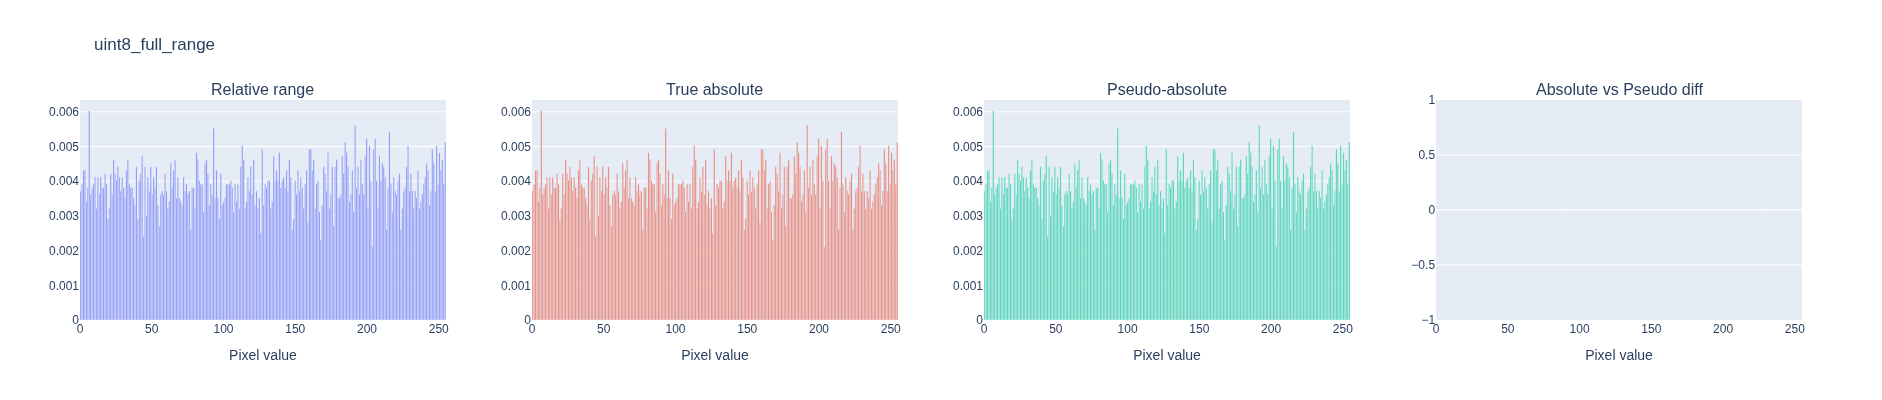

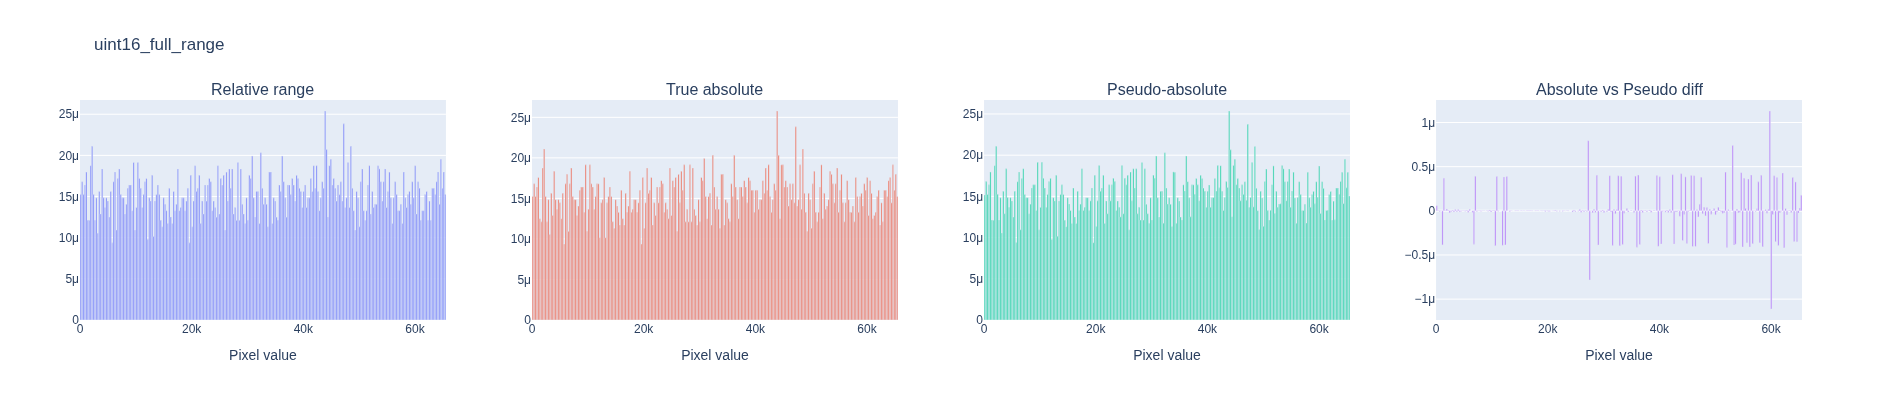

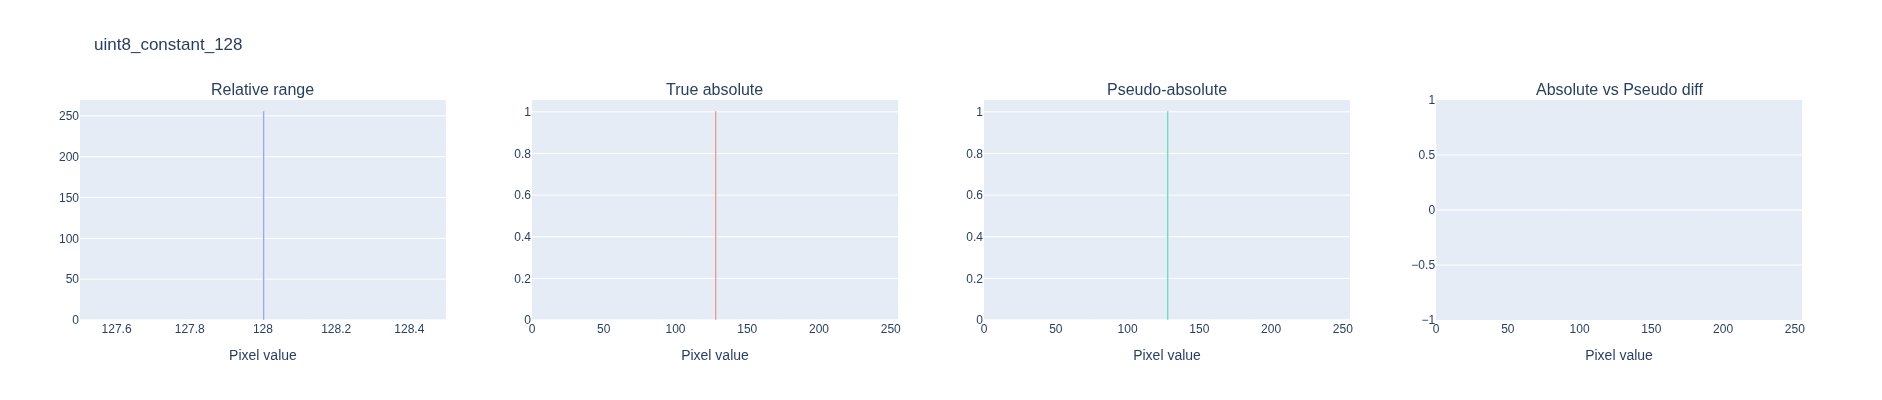

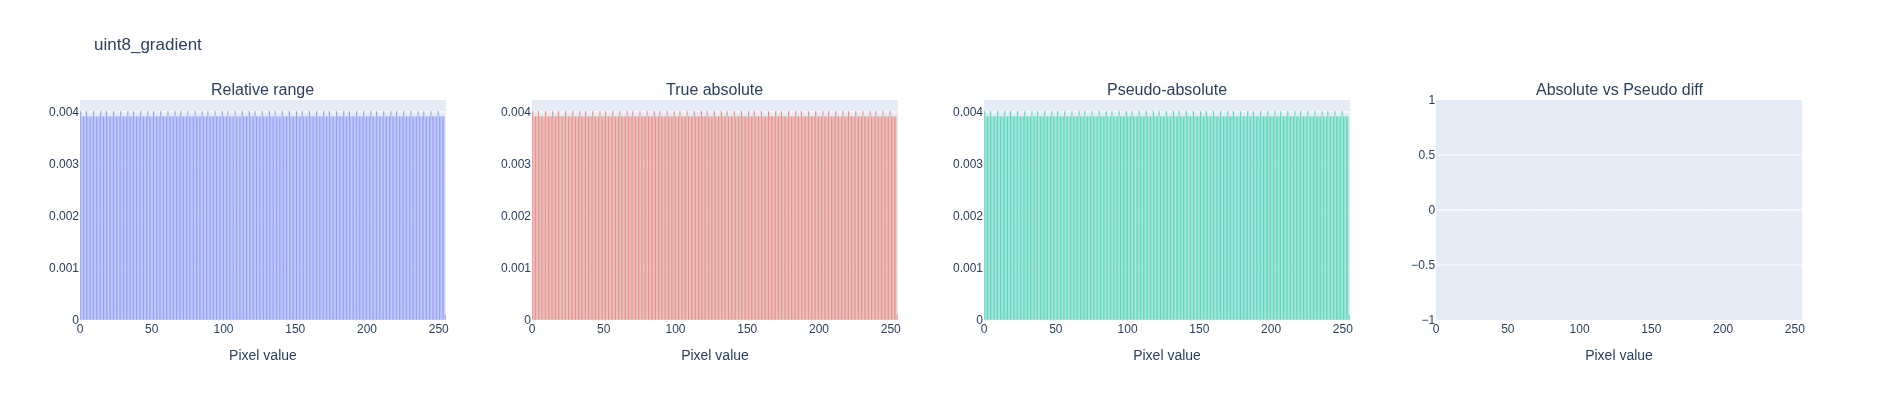

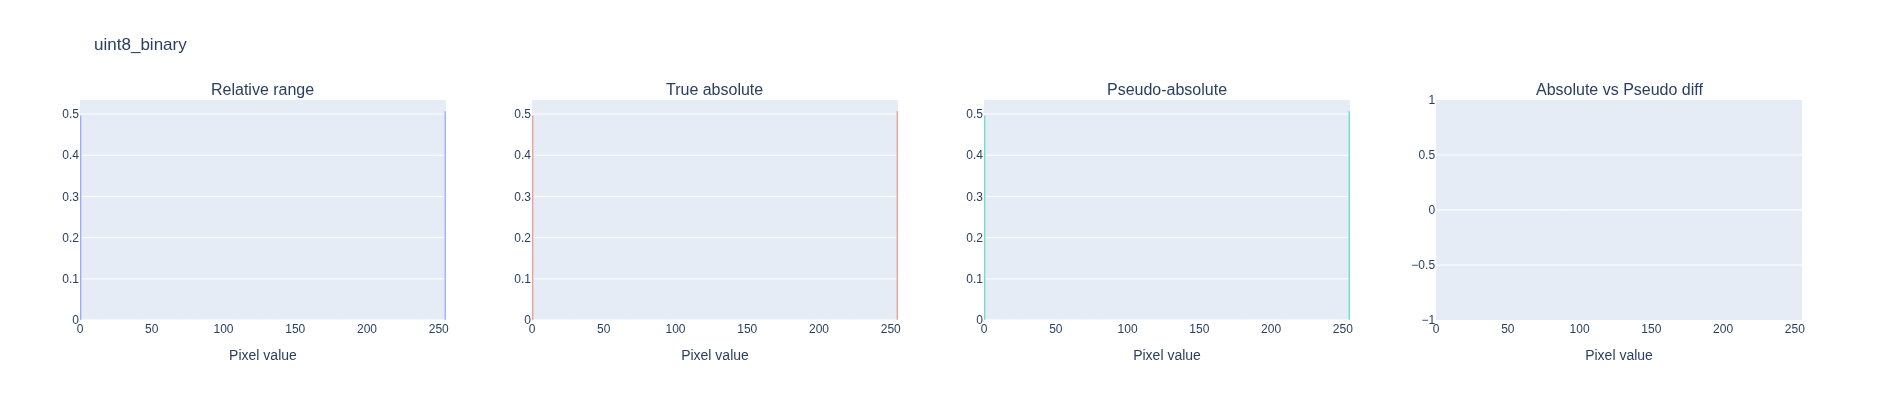

In [6]:
for name, img in generate_test_images().items():
    plot_histograms(img, title=name)